In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

print("")

import torch
import numpy as np

import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")



# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0

PyTorch version: 2.3.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [19]:
import cv2
import numpy as np

def build_pyramid(image, max_level=5):
    pyramid = [image]
    for _ in range(max_level):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(image, max_level=5):
    gaussian_pyramid = build_pyramid(image, max_level)
    laplacian_pyramid = []
    for i in range(max_level):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

def fuse_pyramids(pyramids):
    fused_pyramid = []
    levels = len(pyramids[0])
    for level in range(levels):
        layer_fusion = np.mean([pyr[level] for pyr in pyramids], axis=0)
        fused_pyramid.append(layer_fusion)
    return fused_pyramid

def reconstruct_from_pyramid(lap_pyramid):
    image = lap_pyramid[-1]
    for layer in reversed(lap_pyramid[:-1]):
        size = (layer.shape[1], layer.shape[0])
        image = cv2.pyrUp(image, dstsize=size)
        image = cv2.add(image, layer)
    return image

class Fusion:
    def __init__(self, input_images):
        self.input_images = input_images

    def resize_images(self, target_size=(256, 256)):
        resized_images = []
        for img_path in self.input_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_img)
        return resized_images

    def fuse(self):
        input_images = self.resize_images()
        laplacian_pyramids = [laplacian_pyramid(img, 5) for img in input_images]
        fused_pyramid = fuse_pyramids(laplacian_pyramids)
        fused_image = reconstruct_from_pyramid(fused_pyramid)
        return fused_image

# Example usage
if __name__ == '__main__':
    input_images = ['/Users/chintubharath/Documents/sdp/medical1.png', '/Users/chintubharath/Documents/sdp/medical2.png']
    fusion_instance = Fusion(input_images)
    fused_image = fusion_instance.fuse()
    cv2.imwrite('/Users/chintubharath/Documents/sdp/outputs/vgg_output_image.png', fused_image)
    print("Fusion completed. Fused image saved.")


Fusion completed. Fused image saved.


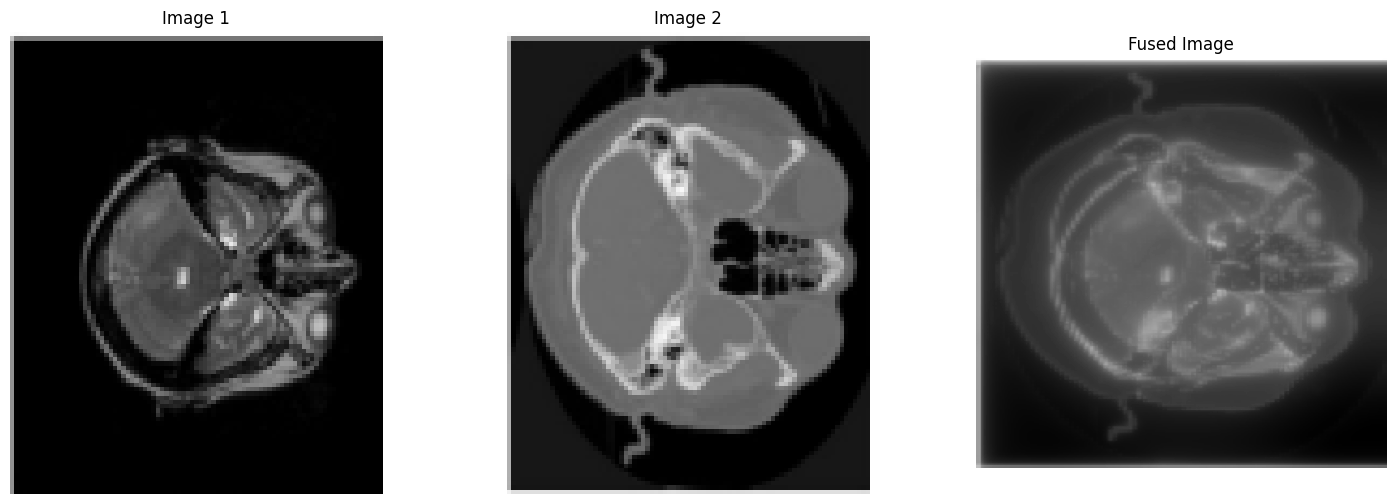

In [20]:
import matplotlib.pyplot as plt
import cv2

# Load the original images and the fused image
img1_path = '/Users/chintubharath/Documents/sdp/medical1.png'
img2_path = '/Users/chintubharath/Documents/sdp/medical2.png'
fused_img_path = '/Users/chintubharath/Documents/sdp/outputs/vgg_output_image.png'

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
fused_img = cv2.imread(fused_img_path, cv2.IMREAD_GRAYSCALE)

# Convert from BGR to RGB (applicable if using cv2.IMREAD_COLOR)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# fused_img = cv2.cvtColor(fused_img, cv2.COLOR_BGR2RGB)

# Display the images using matplotlib
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fused_img, cmap='gray')
plt.title('Fused Image')
plt.axis('off')

plt.show()


In [ ]:
# Example usage
image1_path = '/Users/chintubharath/Documents/sdp/medical1.png'
image2_path = '/Users/chintubharath/Documents/sdp/medical2.png'
image1 = cv2.imread(image1_path, cv2.IMREAD_COLOR)
image2 = cv2.imread(image2_path, cv2.IMREAD_COLOR)
fusion_instance = Fusion([image1, image2])
fused_image = fusion_instance.fuse()
cv2.imwrite('/Users/chintubharath/Documents/sdp/outputs/vgg_output_image.png', fused_image)

In [ ]:
/Users/chintubharath/Documents/sdp/medical1.png
/Users/chintubharath/Documents/sdp/medical2.png
/Users/chintubharath/Documents/sdp/outputs/vgg_output_image.png

In [24]:
import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

def build_pyramid(image, max_level=5):
    pyramid = [image]
    for _ in range(max_level):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(image, max_level=5):
    gaussian_pyramid = build_pyramid(image, max_level)
    laplacian_pyramid = []
    for i in range(max_level):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

def fuse_pyramids(pyramids):
    fused_pyramid = []
    levels = len(pyramids[0])
    for level in range(levels):
        layer_fusion = np.mean([pyr[level] for pyr in pyramids], axis=0)
        fused_pyramid.append(layer_fusion)
    return fused_pyramid

def reconstruct_from_pyramid(lap_pyramid):
    image = lap_pyramid[-1]
    for layer in reversed(lap_pyramid[:-1]):
        size = (layer.shape[1], layer.shape[0])
        image = cv2.pyrUp(image, dstsize=size)
        image = cv2.add(image, layer)
    return image

class Fusion:
    def __init__(self, input_images):
        self.input_images = input_images
        self.resnet = models.resnet18(pretrained=True).to('cpu').eval()
        self.transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, img):
        img_tensor = self.transforms(img).unsqueeze(0).to('cpu')
        with torch.no_grad():
            features = self.resnet(img_tensor)
        return features.numpy().squeeze()

    def resize_images(self, target_size=(256, 256)):
        resized_images = []
        for img_path in self.input_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_img)
        return resized_images

    def fuse(self):
        input_images = self.resize_images()
        laplacian_pyramids = [laplacian_pyramid(img, 5) for img in input_images]
        fused_pyramid = fuse_pyramids(laplacian_pyramids)
        fused_image = reconstruct_from_pyramid(fused_pyramid)
        return fused_image

# Example usage
if __name__ == '__main__':
    input_images = ['/Users/chintubharath/Documents/sdp/medical1.png', '/Users/chintubharath/Documents/sdp/medical2.png']
    fusion_instance = Fusion(input_images)
    fused_image = fusion_instance.fuse()
    cv2.imwrite('/Users/chintubharath/Documents/sdp/outputs/resnet.png', fused_image)
    print("Fusion completed. Fused image saved.")


/Users/chintubharath/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chintubharath/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/chintubharath/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Fusion completed. Fused image saved.


In [1]:
import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

def build_pyramid(image, max_level=5):
    pyramid = [image]
    for _ in range(max_level):
        if image.shape[0] < 5 or image.shape[1] < 5:  # Avoid processing too small images
            break
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(image, max_level=5):
    gaussian_pyramid = build_pyramid(image, max_level)
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

def fuse_pyramids(pyramids):
    fused_pyramid = []
    levels = len(pyramids[0])
    for level in range(levels):
        layer_fusion = np.mean([pyr[level] for pyr in pyramids], axis=0)
        fused_pyramid.append(layer_fusion)
    return fused_pyramid

def reconstruct_from_pyramid(lap_pyramid):
    image = lap_pyramid[-1]
    for layer in reversed(lap_pyramid[:-1]):
        size = (layer.shape[1], layer.shape[0])
        image = cv2.pyrUp(image, dstsize=size)
        image = cv2.add(image, layer)
    return image

def plot_images(images, titles, figure_size=(10, 5)):
    plt.figure(figsize=figure_size)
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()
    
    
    
class Fusion:
    def __init__(self, input_images):
        self.input_images = input_images
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resnet = models.resnet18(pretrained=True).to(self.device).eval()
        self.transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct processing
        img_tensor = self.transforms(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            features = self.resnet(img_tensor)
        return features.cpu().numpy().squeeze()

    def resize_images(self, target_size=(256, 256)):
        resized_images = []
        for img_path in self.input_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_img)
        return resized_images
    
    
    def calculate_weights(self, features):
        # Calculate weights using L2 norm of features, this can be modified based on your requirement
        weights = [np.linalg.norm(f, axis=0) for f in features]
        # Normalize weights
        weight_sum = np.sum(weights, axis=0)
        weights = [w / weight_sum for w in weights]
        return weights

    def fuse(self):
        resized_images = self.resize_images(self.input_images, target_size=(224, 224))
        features = [self.extract_features(img) for img in resized_images]
        weights = self.calculate_weights(features)
        # Create an empty array for the fused image
        fused_image = np.zeros_like(resized_images[0])
        for img, weight in zip(resized_images, weights):
            # Weighted sum of images
            fused_image += img * weight[:, :, np.newaxis]  # Ensure weight dimensions match image dimensions
        return fused_image
    
    
# class Fusion:
#     def __init__(self, input_images):
#         self.input_images = input_images
#         self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#         self.resnet = models.resnet18(pretrained=True).to(self.device).eval()
#         self.transforms = Compose([
#             Resize((224, 224)),
#             ToTensor(),
#             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])

#     def extract_features(self, img):
#         img_tensor = self.transforms(img).unsqueeze(0).to(self.device)
#         with torch.no_grad():
#             features = self.resnet(img_tensor)
#         return features.numpy().squeeze()

#     def resize_images(self, target_size=(256, 256)):
#         resized_images = []
#         for img_path in self.input_images:
#             img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if img is None:
#                 raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
#             resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
#             resized_images.append(resized_img)
#         return resized_images

#     def fuse(self):
#         input_images = self.resize_images()
#         laplacian_pyramids = [laplacian_pyramid(img, 5) for img in input_images]
#         fused_pyramid = fuse_pyramids(laplacian_pyramids)
#         fused_image = reconstruct_from_pyramid(fused_pyramid)
#         return fused_image

# Example usage
if __name__ == '__main__':
    input_images = ['/Users/chintubharath/Documents/sdp/medical1.png', '/Users/chintubharath/Documents/sdp/medical2.png']
    fusion_instance = Fusion(input_images)
    fused_image = fusion_instance.fuse()
    cv2.imwrite('/Users/chintubharath/Documents/sdp/outputs/temp.png', fused_image)
    logging.info("Fusion completed. Fused image saved.")
    plot_images(
        [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in input_images] + [fused_image],
        ["Image 1", "Image 2", "Fused Image"]
    )


/Users/chintubharath/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chintubharath/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: resize_images() got multiple values for argument 'target_size'

In [4]:
import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

class Fusion:
    def __init__(self, input_images):
        self.input_images = input_images
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resnet = models.resnet18(pretrained=True).to(self.device).eval()
        self.transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, img):
        # Log original image shape and type
        logging.info(f"Original image type: {type(img)}, shape: {img.shape}")
        
        # Ensure image is in RGB format
        if len(img.shape) == 2 or img.shape[2] == 1:  # if grayscale or single channel
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # if image has an alpha channel
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

        # Log post conversion image shape and type
        logging.info(f"Post conversion image type: {type(img)}, shape: {img.shape}")

        img_tensor = self.transforms(img).unsqueeze(0).to(self.device)
        
        # Log tensor shape and type
        logging.info(f"Image tensor type: {type(img_tensor)}, shape: {img_tensor.shape}")

        with torch.no_grad():
            features = self.resnet(img_tensor)
        
        # Log features shape and type
        logging.info(f"Features type: {type(features)}, shape: {features.shape}")
        
        return features.cpu().numpy().squeeze()

    def resize_images(self, target_size=(256, 256)):
        resized_images = []
        for img_path in self.input_images:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read image in color
            if img is None:
                logging.error(f"Image at {img_path} could not be read. Check the file path and format.")
                raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_img)
            # Log resizing info
            logging.info(f"Resized image type: {type(resized_img)}, shape: {resized_img.shape} for {img_path}")
        return resized_images

    def calculate_weights(self, features):
        # Calculate weights using L2 norm of features
        weights = [np.linalg.norm(f, axis=0) for f in features]
        weight_sum = np.sum(weights, axis=0)
        weights = [w / weight_sum for w in weights]
        return weights

    def fuse(self):
        resized_images = self.resize_images(target_size=(224, 224))
        features = [self.extract_features(img) for img in resized_images]
        weights = self.calculate_weights(features)
        fused_image = np.zeros_like(resized_images[0])
        for img, weight in zip(resized_images, weights):
            fused_image += img * weight
        return fused_image

# Example usage is commented out as per instructions.
if __name__ == '__main__':
    input_images = ['/Users/chintubharath/Documents/sdp/medical1.png', '/Users/chintubharath/Documents/sdp/medical1.png']
    fusion_instance = Fusion(input_images)
    fused_image = fusion_instance.fuse()
    cv2.imwrite('/Users/chintubharath/Documents/sdp/outputs/resnet_bot1.png', fused_image)
    logging.info("Fusion completed. Fused image saved.")




INFO:root:Resized image type: <class 'numpy.ndarray'>, shape: (224, 224, 3) for /Users/chintubharath/Documents/sdp/medical1.png
INFO:root:Resized image type: <class 'numpy.ndarray'>, shape: (224, 224, 3) for /Users/chintubharath/Documents/sdp/medical1.png
INFO:root:Original image type: <class 'numpy.ndarray'>, shape: (224, 224, 3)
INFO:root:Post conversion image type: <class 'numpy.ndarray'>, shape: (224, 224, 3)


TypeError: Unexpected type <class 'numpy.ndarray'>

In [5]:
import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

class Fusion:
    def __init__(self, input_images):
        self.input_images = input_images
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resnet = models.resnet18(pretrained=True).to(self.device).eval()
        self.transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, img):
        # Log original image shape and type
        logging.info(f"Original image type: {type(img)}, shape: {img.shape}")
        
        # Ensure image is in RGB format
        if len(img.shape) == 2 or img.shape[2] == 1:  # if grayscale or single channel
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # if image has an alpha channel
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

        # Log post conversion image shape and type
        logging.info(f"Post conversion image type: {type(img)}, shape: {img.shape}")

        # Convert numpy image to PIL Image for applying transforms
        img = Image.fromarray(img)

        img_tensor = self.transforms(img).unsqueeze(0).to(self.device)
        
        # Log tensor shape and type
        logging.info(f"Image tensor type: {type(img_tensor)}, shape: {img_tensor.shape}")

        with torch.no_grad():
            features = self.resnet(img_tensor)
        
        # Log features shape and type
        logging.info(f"Features type: {type(features)}, shape: {features.shape}")
        
        return features.cpu().numpy().squeeze()

    def resize_images(self, target_size=(256, 256)):
        resized_images = []
        for img_path in self.input_images:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read image in color
            if img is None:
                logging.error(f"Image at {img_path} could not be read. Check the file path and format.")
                raise FileNotFoundError(f"Image at {img_path} could not be read. Check the file path and format.")
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_img)
            # Log resizing info
            logging.info(f"Resized image type: {type(resized_img)}, shape: {resized_img.shape} for {img_path}")
        return resized_images

    def calculate_weights(self, features):
        # Calculate weights using L2 norm of features
        weights = [np.linalg.norm(f, axis=0) for f in features]
        weight_sum = np.sum(weights, axis=0)
        weights = [w / weight_sum for w in weights]
        return weights

    def fuse(self):
        resized_images = self.resize_images(target_size=(224, 224))
        features = [self.extract_features(img) for img in resized_images]
        weights = self.calculate_weights(features)
        fused_image = np.zeros_like(resized_images[0])
        for img, weight in zip(resized_images, weights):
            fused_image += img * weight.astype(img.dtype)  # Ensure weight is same dtype as image for operations
        return fused_image

# Example usage is commented out as per instructions.
if __name__ == '__main__':
    input_images = ['/Users/chintubharath/Documents/sdp/medical1.png', '/Users/chintubharath/Documents/sdp/medical1.png']
    fusion_instance = Fusion(input_images)
    fused_image = fusion_instance.fuse()
    cv2.imwrite('/Users/chintubharath/Documents/sdp/outputs/resnet_bot1.png', fused_image)
    logging.info("Fusion completed. Fused image saved.")




INFO:root:Resized image type: <class 'numpy.ndarray'>, shape: (224, 224, 3) for /Users/chintubharath/Documents/sdp/medical1.png
INFO:root:Resized image type: <class 'numpy.ndarray'>, shape: (224, 224, 3) for /Users/chintubharath/Documents/sdp/medical1.png
INFO:root:Original image type: <class 'numpy.ndarray'>, shape: (224, 224, 3)
INFO:root:Post conversion image type: <class 'numpy.ndarray'>, shape: (224, 224, 3)
INFO:root:Image tensor type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 224, 224])
INFO:root:Features type: <class 'torch.Tensor'>, shape: torch.Size([1, 1000])
INFO:root:Original image type: <class 'numpy.ndarray'>, shape: (224, 224, 3)
INFO:root:Post conversion image type: <class 'numpy.ndarray'>, shape: (224, 224, 3)
INFO:root:Image tensor type: <class 'torch.Tensor'>, shape: torch.Size([1, 3, 224, 224])
INFO:root:Features type: <class 'torch.Tensor'>, shape: torch.Size([1, 1000])
INFO:root:Fusion completed. Fused image saved.
